In [1]:
%matplotlib inline

import sys
import os
sys.path.append("../../../..")

import numpy as np
import re
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from sklearn.model_selection import KFold, LeavePOut
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

import statsmodels.api as sm



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Get Rasters Informations, size, Geotransform... following one of the grid

In [2]:
#=================================
ImagesFolder = '../../../Images/Acolite/S2A_OPER_MSI_L1C_TL_SGS__20160624T021134_A005246_T58KFA_N02.04/T58KFA/'
#=================================
raster_wavelength = ['560']
#=================================
raster_Name = ['S2A_MSI_2016_06_23_23_12_14_T58KFA_rhos_' + l + '.tif' for l in raster_wavelength]
#=================================

src_ds = gdal.Open(ImagesFolder+raster_Name[0], gdal.GA_ReadOnly)
band = src_ds.GetRasterBand(1)
GT_ds = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()
RasterHeight, RasterWidth = (src_ds.RasterYSize, src_ds.RasterXSize)
print(RasterHeight, RasterWidth)

8664 10980


In [3]:
# Load Data at reduce backup size
#=================================
RatiosId = 1
#=================================
RatioType = ['Done','Raw']
RatioPath = ['../../CompressedData/SRXData.npz','../../CompressedData/SRXData_Raw.npz']
npzfile = np.load(RatioPath[RatiosId])
ClassifyIndex = npzfile['ClassifyIndex'] # Optical data at croped shape (reduce backup size)


## Define ROI footprint

Upper left corner :  (166.32518607799838, -22.16976115382232) 
Lower right corner :  (166.5845673959963, -22.612767748728558)


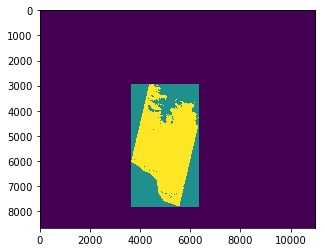

In [4]:
u,v = np.where(ClassifyIndex)
North = (u[np.argmin(u)],v[np.argmin(u)])
South = (u[np.argmax(u)],v[np.argmax(u)])
West = (u[np.argmin(v)],v[np.argmin(v)])
East = (u[np.argmax(v)],v[np.argmax(v)])

max_y, min_y = mgp.Get_ProjectedCoordinate(GT_ds, North)[1], mgp.Get_ProjectedCoordinate(GT_ds, South)[1]
max_x, min_x = mgp.Get_ProjectedCoordinate(GT_ds, East)[0], mgp.Get_ProjectedCoordinate(GT_ds, West)[0]

Check = np.full(ClassifyIndex.shape, 0, int)
Check[np.min(u): np.max(u), np.min(v): np.max(v)] = 1
Check[ClassifyIndex] = 2
plt.imshow(Check)
# Define Raster Footprint
srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, max_N), '\nLower right corner : ', (max_E, min_N))

## Get surveyfiles (ascii), having measurement contained in rasters footprint

In [5]:
# Select xml datafiles following common extent
RePath_xmlDirectory = '../../../../Data_SHOM/Global'
#=================================
TimeThres = 1970
#=================================
#%timeit mgp.GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N))
#%timeit mgp.GetXml_byFootprint2(RePath_xmlDirectory, min_E, max_E, min_N, max_N)
Selected_xml, LoopCount, count = mgp.GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)
#print('Selected_xml :')
#[print(xml) for xml in Selected_xml]
# Select xml datafiles following maximum depth
#=================================
Upto = 100
#=================================
Set , Count, failedXml = mgp.GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
assert np.sum(Count) == Set[1].shape[0]

In [6]:
TideCorrected = True
infcorList = [ET.parse(RePath_xmlDirectory+'/'+xml).getroot().find('Attribute[@name="infcor"]').find('Value').text for xml in Selected_xml]
infcorList
IndexNoumea = ['Marée observée à' in infcorList[i] or
               'marégraphe' in infcorList[i] or
               'Reduit de la maree' in infcorList[i] or
               'reduite de la maree' in infcorList[i] or
               'reduits de la maree' in infcorList[i] or
               'reduites de la maree' in infcorList[i] or
               'réduites de la marée' in infcorList[i] or
               'réduite de la marée' in infcorList[i] or
               'corrigees de la maree' in infcorList[i] or
               'corrigées de la marée' in infcorList[i] or
               'corrigée de la marée' in infcorList[i] or
               'corrigée de la marée' in infcorList[i] or
               'corrigees de la celerite et de la maree' in infcorList[i] and
               'Non reduit de la maree' not in infcorList[i] and
               'non reduite de la maree' not in infcorList[i] and
               'non reduits de la maree' not in infcorList[i] and
               'non reduites de la maree' not in infcorList[i] and
               'non réduites de la marée' not in infcorList[i] and
               'non réduite de la marée' not in infcorList[i] and
               'non corrigees de la maree' not in infcorList[i] and
               'non corrigées de la marée' not in infcorList[i] and
               'non corrigée de la marée' not in infcorList[i] and
               'non corrigée de la marée' not in infcorList[i] and
               'non corrigees de la celerite et de la maree' not in infcorList[i] 
               for i in range(len(infcorList))]
#[Selected_xml[i] for i in IndexNoumea[0]]
NotCorInd = np.where([inde==False for inde in IndexNoumea])
try:
    assert len([infcorList[i] for i in NotCorInd[0]]) == 0
except AssertionError:
    TideCorrected = False
    print('Warning: No proof of tide correction for file: ',NotCorInd[0])

 37 86 87]


In [7]:
#[print(infcorList[i]) for i in NotCorInd[0]]

In [8]:
if not TideCorrected:
    Selected_xml = [Selected_xml[i] for i in range(len(Selected_xml)) if IndexNoumea[i]==True]
    # Select xml datafiles following maximum depth
    Upto = 100
    Set , Count, failedXml = mgp.GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)

##  Convert measurements coordinate in pixels coordinate (+ checking process)

In [9]:
# Define pixel location of measured data
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)

# Project coordinates in pixel coordinates then filter measured data projected outside image extent
px, py = mgp.GetPixel(ctInv, inv_geometrix, Set[1],integer=False)
indexOut = np.logical_or(np.logical_or(py>RasterHeight-1,py<0), np.logical_or(px>RasterWidth-1,px<0))
px, py = px[~indexOut], py[~indexOut]

# Adjust water depth following the Tide at the image sensor Time
#=================================
TideHeight = 1.29 # Height of tide from SHOM website 
#=================================
depth=Set[2]
depth = depth[~indexOut]+TideHeight

# filter measured data with negative depth (due to tide)
indexOut = depth<0
print('Number of point with negative depth :', np.sum(indexOut))
px, py, depth = px[~indexOut], py[~indexOut], depth[~indexOut]
assert px.shape==py.shape and px.shape == depth.shape

no int
Number of point with negative depth : 9


## Get workingIndex or Index of classification and bathymetry mapping
###### In others words :        ClassifyIndex = ~Soil x ~DeepOcean x CroppedImage
######                                     ClassifyIndex.shape == Initial_Rasters.shape

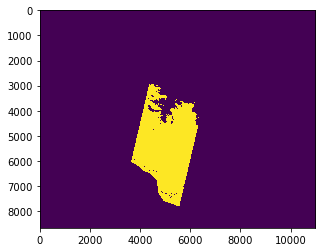

In [10]:
plt.imshow(ClassifyIndex)

## Create index(SurveyIndex) indicating the presence of measurements in a pixel
## Create dictionary(Dicto) of depths measured at a pixel location

In [11]:
# Create sub (2d) index for measured pixel
SurveyIndex = np.full(ClassifyIndex.shape, 0, dtype=np.int8)
DictoDeph = {}
DictoPos = {}
count, Npx = 0, len(px)
for i in range(len(px)):
    Intpy, Intpx = int(py[i]),int(px[i])
    try:
        if ClassifyIndex[Intpy, Intpx] == False: # Case for Poe int(px)
            continue
        SurveyIndex[Intpy, Intpx] += 1
        if SurveyIndex[Intpy, Intpx] == 1:
            DictoDeph[Intpy, Intpx] = []
            DictoPos[Intpy, Intpx] = []
            DictoDeph[Intpy, Intpx].append(depth[i])
            DictoPos[Intpy, Intpx].append([py[i], px[i]])
        else:
            DictoDeph[Intpy, Intpx].append(depth[i])
            DictoPos[Intpy, Intpx].append([py[i], px[i]])
    except:
        print(i)
    count = count + 1


Number of pixels containing measurements:  207800


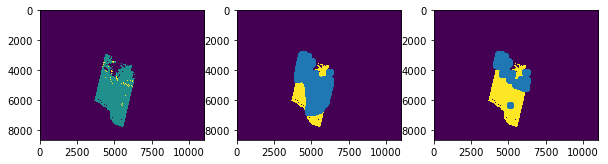

In [12]:


print('Number of pixels containing measurements: ',np.sum(SurveyIndex>0))
display = np.full(ClassifyIndex.shape, 0, np.int8)
display[ClassifyIndex] = 1
display[SurveyIndex>0] = 2

fig, ax = plt.subplots(1,3, figsize = (10,5))
ax[0].imshow(display)

ax[1].imshow(ClassifyIndex)
u_surv, v_surv = np.where(SurveyIndex>0)
ax[1].scatter(v_surv, u_surv)

ax[2].imshow(ClassifyIndex)
u_surv, v_surv = np.where(SurveyIndex>10)
ax[2].scatter(v_surv, u_surv)



## Compute Statistics on pixels containing measurements 

In [13]:
SurveyRatio = np.full(ClassifyIndex.shape, np.NaN, dtype= np.float_)
SurveyDisposition = {}
NPix = len(DictoDeph.keys())
count = 0
percent = 0
for i, j  in DictoDeph.keys():
    assert len(DictoPos[(i, j)]) == len(DictoDeph[(i, j)])
    Points = np.asarray(DictoPos[(i, j)])
    SurveyRatio[i, j], SurveyDisposition[i, j] = mgp.get_OccupiedRatio(Points[:,0], Points[:,1], radius=0.1)
    count = count + 1
    percent = int(100*count/NPix)
    print('Percent of Ratios Computed: {0}%'.format(percent), end='\r') 
    

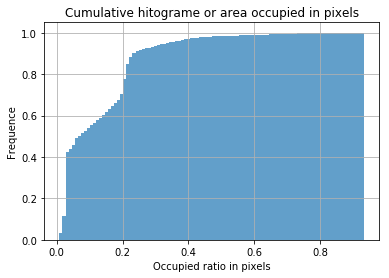

In [14]:
n, bins, patches = plt.hist(SurveyRatio[~np.isnan(SurveyRatio)], 100, alpha=0.7, histtype='stepfilled', cumulative=1, normed=True)
plt.grid()
plt.xlabel('Occupied ratio in pixels')
plt.ylabel('Frequence')
plt.title('Cumulative hitograme or area occupied in pixels')


In [16]:
#=================================
CoverThreshold = 0.25 # Filter pixel with only one measure at less than 1 meter of the border
#=================================
print('Nombre de Pixels Totale : {0:d}\nNombre de Pixels conservé: {1:d}'.format(np.sum(~np.isnan(SurveyRatio)),np.sum(SurveyRatio>CoverThreshold))) 

Nombre de Pixels Totale : 211684
Nombre de Pixels conservé: 18812


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [18]:
SurveyValues = np.full(ClassifyIndex.shape, np.NaN, dtype= np.float_)
SurveyIndex = np.full(ClassifyIndex.shape, False, dtype=np.bool_)
PixMethod = ['nearest', 'linear']
PixMethodIndex = 0
NPixCoverd = np.sum(SurveyRatio>CoverThreshold)
count = 0
percent = 0

rows, cols = np.where(SurveyRatio>CoverThreshold)
for i, j  in zip(rows,cols):
    Points = np.asarray(DictoPos[(i, j)])
    SurveyValues[i, j] = mgp.InterpPixDepth(Points, 
                                            DictoDeph[i, j], 
                                            modes=[PixMethod[PixMethodIndex]], 
                                            delta=0.05,
                                            PlotArg=False)[0]
    SurveyIndex[i, j] = True
    
    count = count + 1
    percent = int(100*count/NPixCoverd)
    print('Percent of Interpolated Depths Computed: {0}%'.format(percent), end='\r') 
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


Percent of Interpolated Depths Computed: 1%

Percent of Interpolated Depths Computed: 6%

Percent of Interpolated Depths Computed: 10%

Percent of Interpolated Depths Computed: 13%

Percent of Interpolated Depths Computed: 16%

Percent of Interpolated Depths Computed: 17%

Percent of Interpolated Depths Computed: 19%

Percent of Interpolated Depths Computed: 22%

Percent of Interpolated Depths Computed: 25%

Percent of Interpolated Depths Computed: 26%

Percent of Interpolated Depths Computed: 27%

Percent of Interpolated Depths Computed: 29%

Percent of Interpolated Depths Computed: 34%

Percent of Interpolated Depths Computed: 40%

Percent of Interpolated Depths Computed: 47%

Percent of Interpolated Depths Computed: 52%

Percent of Interpolated Depths Computed: 60%

Percent of Interpolated Depths Computed: 63%

Percent of Interpolated Depths Computed: 71%

Percent of Interpolated Depths Computed: 74%

Percent of Interpolated Depths Computed: 78%

Percent of Interpolated Depths Computed: 80%

Percent of Interpolated Depths Computed: 84%

Percent of Interpolated Depths Computed: 87%

Percent of Interpolated Depths Computed: 89%

Percent of Interpolated Depths Computed: 95%

34.833767313019393

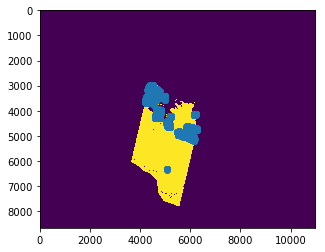

In [19]:
fig, ax = plt.subplots(1,1)

ax.imshow(ClassifyIndex)
u_surv, v_surv = np.where(SurveyIndex)
ax.scatter(v_surv, u_surv)
np.nanmax(SurveyValues)

## Load Optical Data
### WARNING: Poe special case -> to avoid bigger backup size, data need to be resize at Rasters dimension

In [20]:
# Load Data at reduce backup size
#=================================
RatiosId = 1
#=================================
RatioType = ['Done','Raw']
RatioPath = ['../../CompressedData/SRXData.npz','../../CompressedData/SRXData_Raw.npz']
npzfile = np.load(RatioPath[RatiosId])
X = npzfile['Ratios'] # Optical data at croped shape (reduce backup size)
RatiosKeys = npzfile['Keys'] # Keys defining order of recorded ratios 

X.shape

(8664, 10980, 10)

## Special case in Poe, Area of interest for specific calibration manually created

In [21]:
ShapeFolder = '../../ShapesAndMask/'
RoiPathName = ['None']
#=================================
Roidescription = ['Pas de restriction de la zone de calibration à l''intérieur du lagon']
CalibZoIndex = 0
#=================================

ResctictedLagoon = ClassifyIndex

## Visual check !

## Creation of calibration dataset

In [22]:
assert X.shape[:2]==SurveyValues.shape
ind = ResctictedLagoon * (SurveyIndex) # Index of calibration data
Data_x = X[ind,:] # model optical descriptors
Data_y = SurveyValues[ind].reshape(np.sum(ind),) # model target depth

## release memory

In [23]:
del X

In [24]:
invalidCalibValue = np.sum(np.isnan(Data_x),axis=1)>0
Data_x, Data_y = Data_x[~invalidCalibValue,:], Data_y[~invalidCalibValue]
print('Number of Invalide calibreation Value : ', np.sum(invalidCalibValue))

Number of Invalide calibreation Value :  0


In [25]:
ind[np.where(ind)[0][invalidCalibValue],np.where(ind)[1][invalidCalibValue]]=False

## exploratory statistics

['Red' 'ExtraRed'] correlation :  -0.0902595454675
['Green' 'ExtraRed'] correlation :  -0.422167244414
['Blue' 'ExtraRed'] correlation :  0.16358319952
['ExtraBlue' 'ExtraRed'] correlation :  0.333517204758
['Green' 'Red'] correlation :  -0.456154394545
['Blue' 'Red'] correlation :  0.250075627993
['ExtraBlue' 'Red'] correlation :  0.415208230082
['Blue' 'Green'] correlation :  0.865475681622
['ExtraBlue' 'Green'] correlation :  0.852523134657
['ExtraBlue' 'Blue'] correlation :  0.49646922412


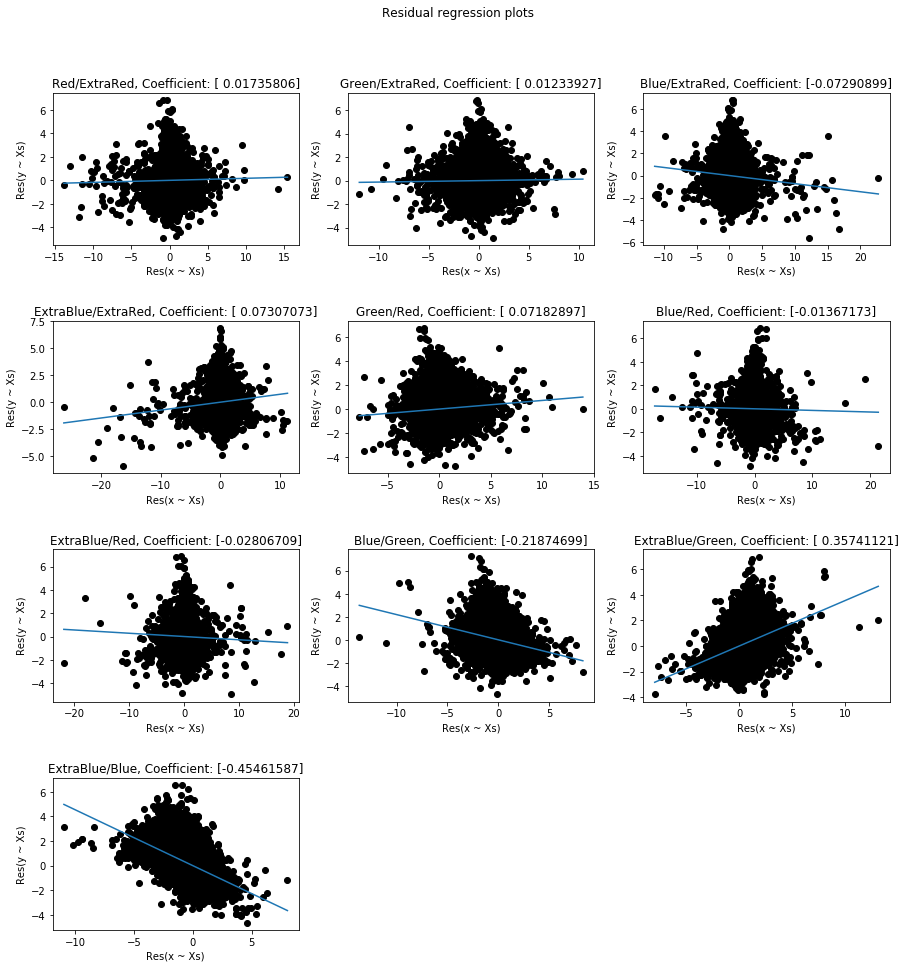

In [26]:
for i in range(Data_x.shape[1]):
    print(str(RatiosKeys[i]),'correlation : ',np.corrcoef(Data_x[:,i],Data_y)[0,1])
    print("="*10)
mgp.plot_ResRegPlots(Data_x, Data_y, Scale=True, SetTitles=True, Titles=[str(i)+'/'+str(j) for i,j in RatiosKeys])

In [26]:

cc= SurveyRatio[ind].reshape(np.sum(ind),)
cc = 1*((cc-cc.min())/(cc.max()-cc.min()))


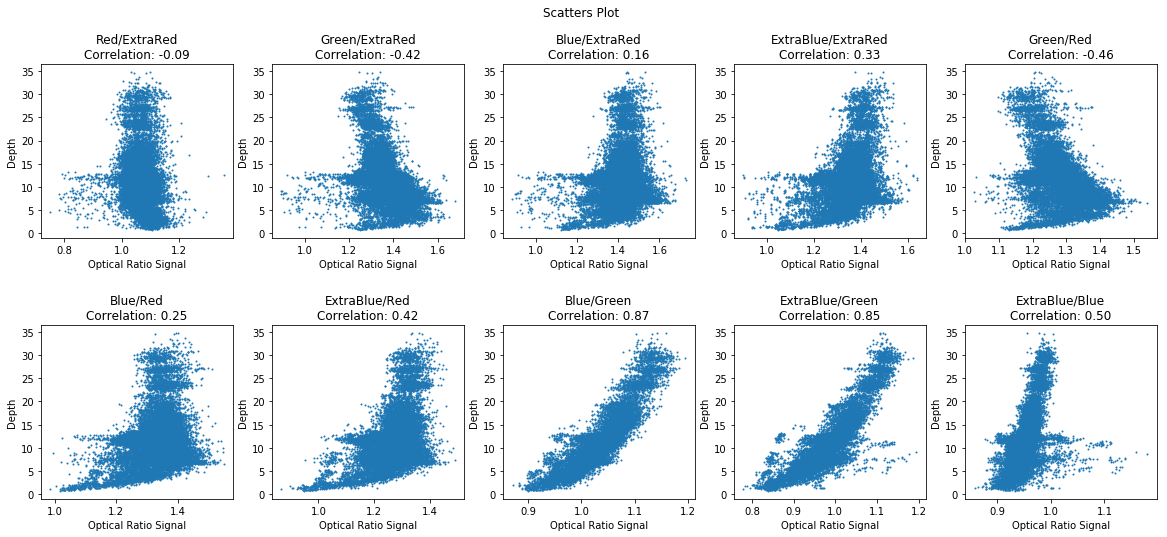

In [27]:
fig, axes = plt.subplots(2,5, figsize=(20, 8))
fig.suptitle('Scatters Plot')
fig.subplots_adjust(hspace=.5, top=.88)
colorsCover= SurveyRatio[ind].reshape(np.sum(ind),)
for i, ax in enumerate(fig.axes):
    ax.scatter(Data_x[:,i],Data_y, s=1)
    #ax.scatter(Data_x[:,i],Data_y, c=cc,cmap='jet', s=1)
    #mgp.ScatterDensity(ax, Data_x[:,i],Data_y, Map=False, Bandw='scott',ScatterOptions={'s':1})
    ax.set_title(RatiosKeys[i][0]+'/'+RatiosKeys[i][1]+'\nCorrelation: {0:0.2f}'.format(np.corrcoef(Data_x[:,i],Data_y)[0,1]))
    ax.set_ylabel('Depth')
    ax.set_xlabel('Optical Ratio Signal')


In [257]:
help(mgp.ScatterDensity)

Help on function ScatterDensity in module my_packages.My_Geoprocess:

ScatterDensity(ax, xx, yy, Bandw, Map=True, ScatterOptions={}, MapOptions={})
    Should perform a density computation for scatter plot color or density map plot
    but gaussian_kde seems to provide wrong elongated gaussian



In [27]:
x = Data_x
y = Data_y

# Simple linear Regression (Stumpf)

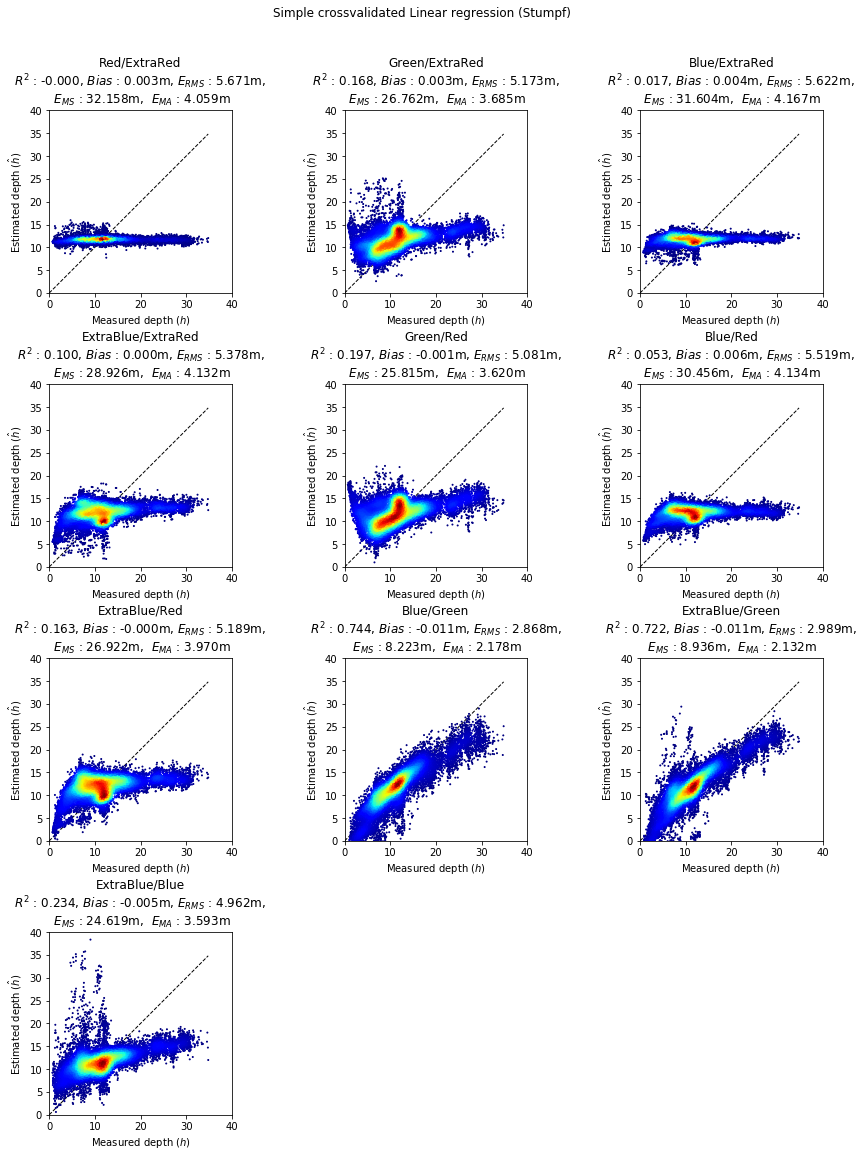

In [29]:
plotsPerRows = 3
fig , axes = plt.subplots(int(np.ceil(x.shape[1]/plotsPerRows)),plotsPerRows, figsize=(15,18))
fig.suptitle('Simple crossvalidated Linear regression (Stumpf)')
fig.subplots_adjust(hspace=.5, top=.9)
Outputs = []

for i, ax in enumerate(fig.axes):
    if i >= x.shape[1]:
        ax.set_visible(False)
        continue
    Outputs.append(mgp.my_LeaveOneOutCV(linear_model.LinearRegression(), 
                                        x[:,i].reshape(-1,1), y, 
                                        ax=ax, SetTitles= True, 
                                        Titles=RatiosKeys[i][0]+'/'+RatiosKeys[i][1],
                                        spliting=KFold, ArgSplit={'n_splits':200},
                                        ScatterOpt={'s': 1},Density=True))
    ax.set_xlim(0,40)
    ax.set_ylim(0,40)
plt.show()

# Simple Multi-linear Regression (Stumpf)

(0, 40)

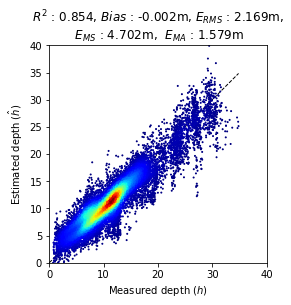

In [46]:
Outputs = []

Outputs.append(mgp.my_LeaveOneOutCV(linear_model.LinearRegression(), 
                                    x, y,
                                    spliting=KFold, ArgSplit={'n_splits':200},
                                    ScatterOpt={'s': 1},Density=True))
plt.xlim(0,40)
plt.ylim(0,40)

# 2 Iterations Simple Multi-linear Regression (Stumpf)

(0, 40)

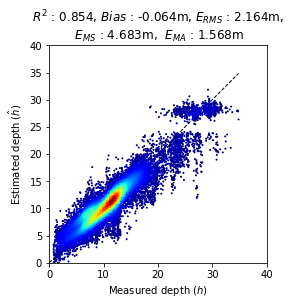

In [33]:
lr = mgp.my_2IterationsModel(linear_model.LinearRegression, [24.5])
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y,
                                    spliting=KFold, ArgSplit={'n_splits':200},
                                    ScatterOpt={'s': 1},Density=True))
plt.xlim(0,40)
plt.ylim(0,40)

# Multi-linear : Ridge Regression

Best MAE : 1.578 with alpha = exp(-10.00)
Best R2 : 0.854 with alpha = exp(-4.13)



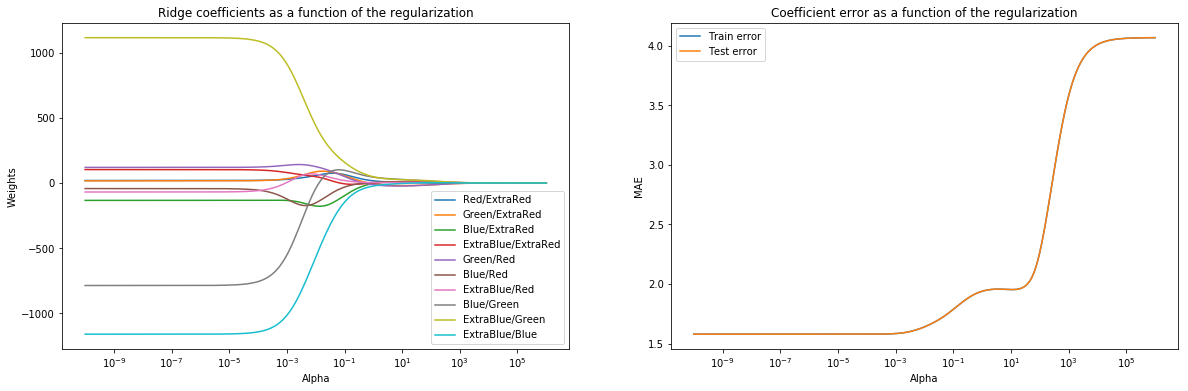

In [32]:
Nalphas = 200
alphas = np.logspace(-10, 6, Nalphas)
Outputs = []
count = 0

for a in alphas:
    lr = linear_model.Ridge(alpha=a)
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False,
                                    spliting=KFold, ArgSplit={'n_splits':200}))
    count = count +1
    print('Percent of complexity computed: {0}%'.format(int(100*count/Nalphas)), end='\r')
    

coefs = [Outputs[i][1]['Coefs'] for i in range(len(alphas))]
MAE = [Outputs[i][1]['MAE'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_MAE = [Outputs[i][1]['tr_MAE'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]

# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Ridge coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )
ax[1].plot(alphas, tr_MAE, label='Train error')
ax[1].plot(alphas, MAE, label='Test error')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('MAE')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')

fig.show

print('Best MAE : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(MAE), np.log10(alphas[np.argmin(MAE)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

(0, 40)

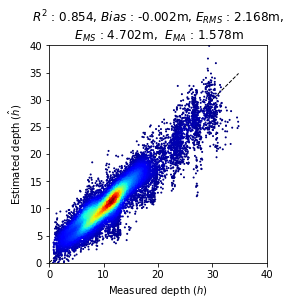

In [33]:
a = alphas[np.argmin(MAE)]
lr = linear_model.Ridge(alpha=a)
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y,
                                    ScatterOpt={'s': 1},Density=True,
                                    spliting=KFold, ArgSplit={'n_splits':200},
                                    DoPlot=True))
plt.xlim(0,40)
plt.ylim(0,40)

# Multi-linear : 2 Iterations Ridge Regression

Best MAE : 1.567 with alpha = exp(-10.00)
Best R2 : 0.854 with alpha = exp(-10.00)



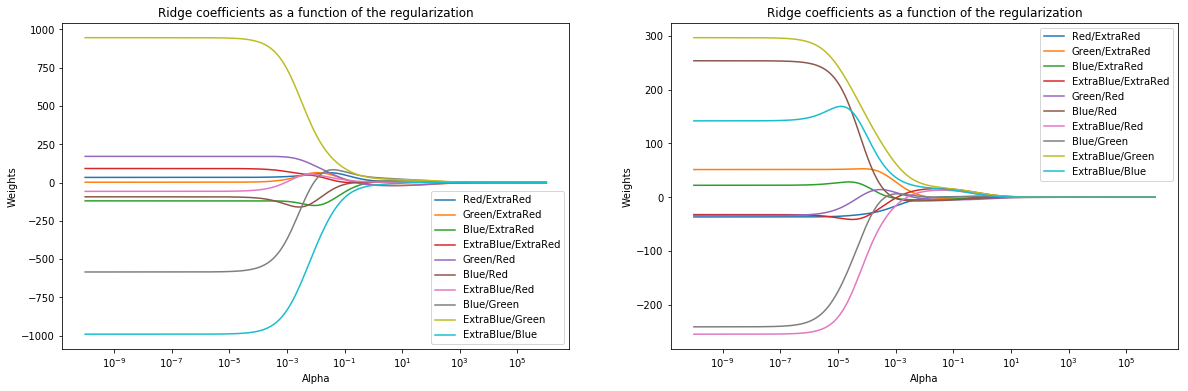

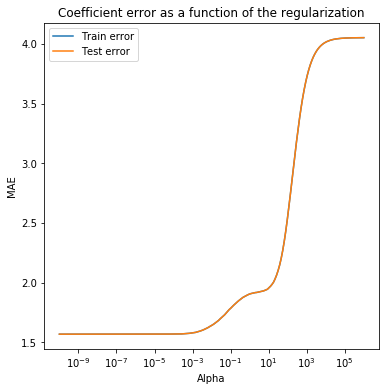

In [34]:
Nalphas = 200
alphas = np.logspace(-10, 6, Nalphas)

Outputs = []
count = 0

for a in alphas:
    lr = mgp.my_2IterationsModel(linear_model.Ridge, [24.5], ModelsArguments={'alpha':a})
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False, spliting=KFold, ArgSplit={'n_splits':200}))
    count = count +1
    print('Percent of complexity computed: {0}%'.format(int(100*count/Nalphas)), end='\r')

#==============================================================    
coefs0 = [Outputs[i][1]['Coefs'][0] for i in range(len(alphas))]
coefs1 = [Outputs[i][1]['Coefs'][1] for i in range(len(alphas))]
#==============================================================

MAE = [Outputs[i][1]['MAE'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_MAE = [Outputs[i][1]['tr_MAE'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]

# Display results
#==============================================================
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))
ax[0].plot(alphas, coefs0)
ax[1].plot(alphas, coefs1)
#==============================================================

[ax[i].set_xscale('log') for i in range(2)]
[ax[i].set_xlabel('Alpha')for i in range(2)]
[ax[i].set_ylabel('Weights')for i in range(2)]
[ax[i].set_title('Ridge coefficients as a function of the regularization')for i in range(2)]
[ax[i].axis('tight')for i in range(2)]
[ax[i].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )for i in range(2)]
fig.show

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(alphas, tr_MAE, label='Train error')
ax.plot(alphas, MAE, label='Test error')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Alpha')
ax.set_ylabel('MAE')
ax.set_title('Coefficient error as a function of the regularization')
ax.axis('tight')


print('Best MAE : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(MAE), np.log10(alphas[np.argmin(MAE)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

(0, 40)

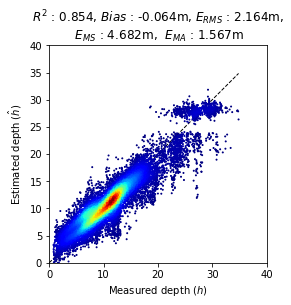

In [35]:
ModArg = {'alpha': alphas[np.argmin(MAE)]}
lr = mgp.my_2IterationsModel(linear_model.Ridge, [24.5], ModelsArguments=ModArg )
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True,
                                    ScatterOpt={'s': 1},Density=True,
                                    spliting=KFold, ArgSplit={'n_splits':200}))
plt.xlim(0,40)
plt.ylim(0,40)

# Multi-linear : Lasso Regression

In [ ]:

alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = linear_model.Lasso(alpha=a, max_iter=10000)
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))

coefs = [Outputs[i][1]['Coefs'] for i in range(len(alphas))]
RMS = [Outputs[i][1]['RMS'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_RMS = [Outputs[i][1]['tr_RMS'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]

# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Lasso coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )
ax[0].grid()
ax[1].plot(alphas, tr_RMS, label='Train error')
ax[1].plot(alphas, RMS, label='Test error')
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')
ax[1].grid()

fig.show

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

In [ ]:
a = alphas[np.argmin(RMS)]
lr = linear_model.Lasso(alpha=a, max_iter=10000)
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))

# 2 Iterations Multi-linear : Lasso Regression

In [ ]:
alphas = np.logspace(-6, 6, 200)
Outputs = []

for a in alphas:
    lr = mgp.my_2IterationsModel(linear_model.Lasso, [6,12], ModelsArguments={'alpha':a, 'max_iter':1000})
    Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))

coefs0 = [Outputs[i][1]['Coefs'][0] for i in range(len(alphas))]
coefs1 = [Outputs[i][1]['Coefs'][1] for i in range(len(alphas))]
coefs2 = [Outputs[i][1]['Coefs'][2] for i in range(len(alphas))]

RMS = [Outputs[i][1]['RMS'] for i in range(len(alphas))]
R2_scores = [Outputs[i][1]['R2_score'] for i in range(len(alphas))]
tr_RMS = [Outputs[i][1]['tr_RMS'] for i in range(len(alphas))]
tr_R2_scores = [Outputs[i][1]['tr_R2_score'] for i in range(len(alphas))]
# Display results
fig, ax = plt.subplots(nrows=1, ncols= 3, figsize=(20, 6))

ax[0].plot(alphas, coefs0)
ax[1].plot(alphas, coefs1)
ax[2].plot(alphas, coefs2)
[ax[i].set_xscale('log') for i in range(3)]
[ax[i].set_xlabel('Alpha')for i in range(3)]
[ax[i].set_ylabel('Weights')for i in range(3)]
[ax[i].set_title('Ridge coefficients as a function of the regularization')for i in range(3)]
[ax[i].axis('tight')for i in range(3)]
[ax[i].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )for i in range(3)]
fig.show

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(alphas, tr_RMS, label='Train error')
ax.plot(alphas, RMS, label='Test error')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Alpha')
ax.set_ylabel('RMS')
ax.set_title('Coefficient error as a function of the regularization')
ax.axis('tight')


print('Best RMS : {0:.3f} with alpha = exp({1:1.2f})\nBest R2 : {2:.3f} with alpha = exp({3:1.2f})\n'.format(
np.min(RMS), np.log10(alphas[np.argmin(RMS)]), np.max(R2_scores), np.log10(alphas[np.argmax(R2_scores)])))

In [ ]:
ModArg = {'alpha': alphas[np.argmin(RMS)], 'max_iter':1000}
lr = mgp.my_2IterationsModel(linear_model.Lasso, [6,12], ModelsArguments=ModArg )
Outputs.append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=True, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))

# Huber Regression

In [ ]:
SizeE, SizeA = 40, 200
epsilons = np.linspace(1.01, 1.40, SizeE)
alphas = np.logspace(-7, 5, SizeA)
RMS = np.full((SizeE,SizeA), np.nan, np.float)
R2_scores = np.full((SizeE,SizeA), np.nan, np.float)
coefs = np.full((SizeE,SizeA,x.shape[1]), np.nan, np.float)

Outputs = []

for ie, e in enumerate(epsilons):
    Outputs.append([])
    for ia, a in enumerate(alphas):
        lr = linear_model.HuberRegressor(alpha=a, epsilon=e, fit_intercept=True, max_iter=1000)
        Outputs[ie].append(mgp.my_LeaveOneOutCV(lr, x, y, DoPlot=False, spliting=KFold, ArgSplit={'n_splits':20, 'shuffle':False}))
    RMS[ie,:] = np.asarray([Outputs[ie][i][1]['RMS'] for i in range(len(alphas))])
    R2_scores[ie,:] = np.asarray([Outputs[ie][i][1]['R2_score'] for i in range(len(alphas))])
    coefs[ie,:,:] = np.asarray([Outputs[ie][i][1]['Coefs'] for i in range(len(alphas))])

bestE_R2, bestA_R2 = np.where(np.max(R2_scores)==R2_scores)
bestE_RMS, bestA_RMS = np.where(np.min(RMS)==RMS)

print('Best RMS : {0:.3f} with alpha = exp({1:1.2f}), epsilons = {2:1.2f}\nBest R2 : {3:.3f} with alpha = exp({4:1.2f}), epsilons = {5:1.2f}\n'.format(
RMS[bestE_RMS, bestA_RMS][0], np.log10(alphas[bestA_RMS][0]), epsilons[bestE_RMS][0], 
R2_scores[bestE_R2, bestA_R2][0], np.log10(alphas[bestA_R2][0]), epsilons[bestE_R2][0]))

In [ ]:
# Display results
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize=(20, 6))

ax[0].plot(alphas, [coefs[bestE_R2,i,:].reshape(-1,) for i in range(len(alphas))])
ax[0].set_xscale('log')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Weights')
ax[0].set_title('Lasso coefficients as a function of the regularization')
ax[0].axis('tight')
ax[0].legend(labels=[str(i)+'/'+str(j) for i,j in RatiosKeys] )
ax[0].grid()
ax[1].plot(alphas, RMS[bestE_R2,:].T)
ax[1].set_xscale('log')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('RMS')
ax[1].set_title('Coefficient error as a function of the regularization')
ax[1].axis('tight')
ax[1].grid()

fig.show

In [ ]:

lr = mgp.my_2IterationsModel(linear_model.HuberRegressor, [5.5, 12], ModelsArguments={'alpha':alphas[bestA_R2], 'epsilon':epsilons[bestE_R2], 'max_iter':10000})
Outputs.append(my_LeaveOneOutCV(lr, x, y, DoPlot=True, spliting=KFold, ArgSplit={'n_splits':100, 'shuffle':False}))

# Restore descriptors data

In [ ]:
# Load Data at reduce backup size
npzfile = np.load(RatioPath[RatiosId])
X = npzfile['Ratios'] # Optical data at croped shape (reduce backup size)

data_x = X[ClassifyIndex, :] # Extract descriptor


# Predict depth of unknown pixels

In [36]:
# Look for Invalid values in descriptors matrix
NanIndex = np.sum(np.asarray([np.isnan(data_x[:,i]) for i in range(data_x.shape[1])]).T,axis=1)>0 
print('Nombre de pixels manquant: ', np.sum(NanIndex))
# Do prediction
modelUsed = Outputs[-1][1]['Model'] # recover the last trained model
Bathy = np.full((data_x.shape[0],), np.nan)
Bathy[~NanIndex] = modelUsed.predict(data_x[~NanIndex])# predict valid pixel

Nombre de pixels manquant:  12


# Set predictions in raster dimension and Correct predictions from Tide

In [38]:
# Set predictions in raster dimension
BathyMap = np.full((RasterHeight, RasterWidth), np.nan)
BathyMap[ClassifyIndex] = Bathy
del Bathy
TideCorrected = False

# Correct predictions from Tide
if not TideCorrected:
    BathyMap = BathyMap - TideHeight
    TideCorrected = True

# Visualize predictions on Image tide level

# Store Metadata in dictionnary and Compute interpolated deviation map

In [ ]:
# Store Metadata in dictionnary
Metadata = {}
#==============================================================================
ImageName = 'S2A_OPER_MSI_L1C_TL_SGS__20160624T021134_A005246_T58KFA_N02.04'
#==============================================================================
Metadata['ImageName'] = ImageName

if type(modelUsed.coef_[0])==np.ndarray:  
    Metadata['Model_coefficients'] = str({str(RatiosKeys[c][0])+'/'+str(RatiosKeys[c][1]):
                                     ['{0:.16f}'.format(modelUsed.coef_[i][c]) 
                                      for i in range(len(modelUsed.intercept_))]
                                      for c in range(len(modelUsed.coef_[0]))})
    Metadata['Model_intercepts'] = str({str(i): '{0:.16f}'.format(modelUsed.intercept_[i]) 
                                        for i in range(len(modelUsed.intercept_))})
else:
    Metadata['Model_coefficients'] = str({str(RatiosKeys[i][0])+'/'+str(RatiosKeys[i][1]):'{0:.16f}'.format(a) for i, a in enumerate(modelUsed.coef_)})
    Metadata['Model_intercepts'] = '{0:.16f}'.format(modelUsed.intercept_)
    
for a in Outputs[-1][1].keys(): 
    if not (a=='Intercept' or a=='Coefs'):
        Metadata[a] = str(Outputs[-1][1][a])

# Compute interpolated deviation map
InterpDevMethode = "nearest"
Ecart = modelUsed.predict(x) - y
DeviationMap = mgp.GetInnerInterp(Ecart, ind, methode = InterpDevMethode)
#==============================================================================
Metadata['Description'] = 'Band1: Depth prediction at zero hydrographic level(de la Station d''Noumea, donc presence d''un biais systematique), Band2: Interpolated deviation map (prediction - true) with '+InterpDevMethode+' method' 
#==============================================================================
Metadata['Description de la Zone de Calibration'] = Roidescription[CalibZoIndex]

BathyRaster = np.stack((BathyMap,DeviationMap), axis=2)
BathyRaster.shape
del BathyMap, DeviationMap

# Write Geotiff raster

In [45]:
BathyFolder = '../../Resultats/Bathymetries/'+ImageName+'/'
TempoFolder = '/vsimem/'
filename = 'Stumpf_NoClass_' + str(modelUsed).split("(")[0] + \
            '_TimeThreshold_'+ str(TimeThres)+ \
            "_GlintProcess_" + RatioType[RatiosId]+ \
            "_PixInterp_" + PixMethod[PixMethodIndex] + \
            "_CoverPixRatio" + '{0:.0f}%_'.format(CoverThreshold*100)+ \
            'CalibZone_'+ RoiPathName[CalibZoIndex][:-4]+ \
            ".tif"
fTempName = TempoFolder + filename
fname = BathyFolder + filename

mgp.write_raster2(fTempName, BathyRaster, GT_ds, proj, DriverName="GTiff", formatMem=gdal.GDT_Float32,Metadata=Metadata, Offset=None)
response = gdal.Translate(destName=fname, srcDS=fTempName, srcWin=(np.min(v), np.min(u),
                                                                   np.max(v)-np.min(v), np.max(u)-np.min(u)))
if response is None:
    print('fail')

In [ ]:
del response

In [ ]:
modelUsed